# 深層学習スクラッチ　ディープニューラルネットワーク

前回は3層のニューラルネットワークを作成したが、今回はこれを任意の層数に拡張しやすいものに書き換えていく。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていく。
このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指す。

In [1]:
#基本ライブラリ
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
#scikit-learnライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

#データセット
#from sklearn.datasets import load_iris

In [37]:
#MNISTデータセット
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#平滑化
X_train_f = X_train.reshape(-1, 784)
X_test_f = X_test.reshape(-1, 784)

#前処理
X_train_ff = X_train_f.astype(np.float)
X_test_ff = X_test_f.astype(np.float)
X_train_ff /= 255
X_test_ff /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

Xt_train, Xt_val, yt_train, yt_val = train_test_split(X_train_ff, y_train_one_hot, test_size=0.2)
print(Xt_train.shape) # (48000, 784)
print(Xt_val.shape) # (12000, 784)
print(yt_train.shape)
print(yt_val.shape)

Using TensorFlow backend.


(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [38]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

クラスにまとめて行くことで、構成を変更しやすい実装にしていく。

手を加える箇所
- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成する。

## SimpleInitializer

In [97]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2) 
        
        return B

In [40]:
# テスト
initializer = SimpleInitializer(sigma= 0.01)
print(initializer.W(4, 10))
print(initializer.B(10))

[[ 0.0144204  -0.01064334  0.0087505  -0.00613603 -0.00827022 -0.00010613
   0.0115088  -0.0073537   0.00166714  0.00399145]
 [-0.01184034 -0.01065672 -0.00433525  0.0056092   0.01542739  0.01040955
  -0.00089129 -0.00911276  0.02147142  0.00482934]
 [-0.00200098  0.01196082 -0.01251828 -0.00322636 -0.01297762 -0.00748901
   0.01322684 -0.00830531 -0.01028293 -0.02016885]
 [ 0.01252299 -0.00230588  0.00670878 -0.01400269  0.00396101 -0.00236878
   0.02688426 -0.02588258  0.00667455  0.00998452]]
[[-0.00310297 -0.00543957  0.00536146  0.00122429 -0.0246055  -0.00251121
   0.02051422 -0.00242131 -0.00165961  0.02034751]]


## 最適化クラス(SGD)

In [138]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.LW
        layer.B -= self.lr*layer.LB


## 活性化関数（tanh）

In [42]:
class Tanh():
    """
    ハイパボリックタンジェント関数
    """
    def forward(self, X):
        return np.tanh(X)
    
    def backward(self, LZ, A):
        return LZ * (1-np.tanh(A)**2) 
    

## 活性化関数(softmax)

In [43]:
class Softmax():
    """
    ソフトマックス関数
    """
    def forward(self, X):
        c = np.max(X, axis=1)
        exp_x = np.exp(X - c.reshape(-1,1))   #オーバーフロー対策
        sum_exp_x = np.sum(exp_x, axis=1)
        y = exp_x / sum_exp_x.reshape(-1,1)

        return y
    
    def backward(self, X):
        print("Softmax backward isn't made yet")
        pass
    

## 全結合層クラス(FC)

In [133]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, def_name=None):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W =  initializer.W(n_nodes1, n_nodes2) 
        self.B = initializer.B(n_nodes2) 
  
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        XW = np.dot(X, self.W)
        self.A = XW + self.B
        
        return self.A
    
    def backward(self, dA, Z, FC_num):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        if FC_num == 0:
            self.LB = np.sum(dA, axis=0)
            self.LW = np.dot(Z.T, self.LA)
            dZ = np.dot(self.LA, self.W.T)
        else:
            self.LB = np.sum(dA, axis=0)
            self.LW = np.dot(Z.T, self.LA)
            dZ = np.dot(self.LA, self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        #FC2 = FC2.optimizer.updata(FC2)
        #FC2 = SGD().update(FC2)
        
        return dZ


## ベーシック機能NN

ここまで作成した機能を組み込んだNNのクラスを作成。

まずは、動くか試してみる。

784 400
400 200
200 10
0 >10 >20 >30 >40 >


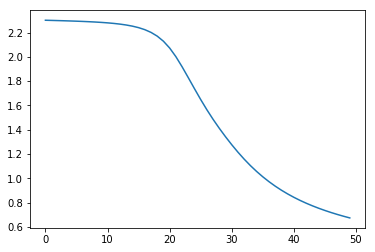

In [64]:
ac_list = [Tanh(), Tanh(), Softmax()]
nodes_num_list = [400, 200, 10]

SDNN = ScratchDeepNeuralNetrowkClassifier(nodes_num_list, ac_list, itr=50, b_size=20, lr=0.00001, network=3)
SDNN.fit(Xt_train, yt_train)
plt.plot(SDNN.L)

### フレームテスト

発展的なコードを実装していない状態で、ノード数、ネットワーク層を色々試してみる

784 400
400 200
200 100
100 10
0 >10 >20 >30 >40 >


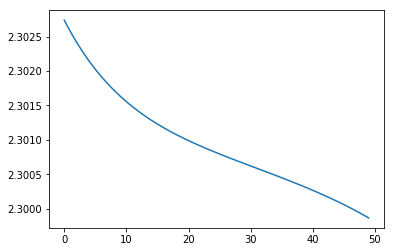

In [65]:
ac_list = [Tanh(),Tanh(), Tanh(), Softmax()]
nodes_num_list = [400, 200, 100, 10]

SDNN = ScratchDeepNeuralNetrowkClassifier(nodes_num_list, ac_list, itr=50, b_size=20, lr=0.00001, network=4)
SDNN.fit(Xt_train, yt_train)
plt.plot(SDNN.L)

層を深くしたら収束が浅くなった

784 200
200 300
300 100
100 10
0 >10 >20 >30 >40 >


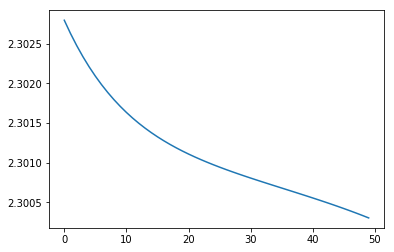

In [69]:
ac_list = [Tanh(),Tanh(), Tanh(), Softmax()]
nodes_num_list = [200, 300, 100, 10]

SDNN3 = ScratchDeepNeuralNetrowkClassifier(nodes_num_list, ac_list, itr=50, b_size=20, lr=0.00001)
SDNN3.fit(Xt_train, yt_train)
plt.plot(SDNN3.L)

784 600
600 10
0 >

/Users/ishizucat/.pyenv/versions/anaconda3-5.3.1/envs/term2/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in log


10 >20 >30 >40 >


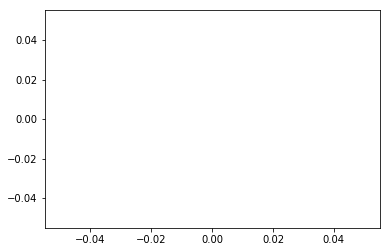

In [70]:
ac_list = [Tanh(),Tanh(), Tanh(), Softmax()]
nodes_num_list = [600, 10]

SDNN4 = ScratchDeepNeuralNetrowkClassifier(nodes_num_list, ac_list, itr=50, b_size=20, lr=0.00001)
SDNN4.fit(Xt_train, yt_train)
plt.plot(SDNN4.L)

784 300
300 200
200 10
0 >

/Users/ishizucat/.pyenv/versions/anaconda3-5.3.1/envs/term2/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in log


10 >20 >30 >40 >


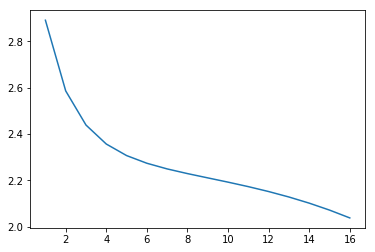

In [71]:
ac_list = [Tanh(),Tanh(), Tanh(), Softmax()]
nodes_num_list = [300, 200, 10]

SDNN4 = ScratchDeepNeuralNetrowkClassifier(nodes_num_list, ac_list, itr=50, b_size=20, lr=0.00001)
SDNN4.fit(Xt_train, yt_train)
plt.plot(SDNN4.L)

## ReLUクラス

In [80]:
class relu():
    def __init__(self):
        self.mask = None

    def forward(self, X):
        self.mask = (X <= 0)
        return np.maximum(0, X)
    
    def backward(self, LZ, A):
        LZ[self.mask] = 0
        dx = LZ
        return dx 
    

0 >10 >20 >30 >40 >


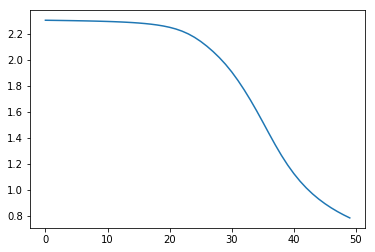

In [83]:
ac_list = [Tanh(), relu(), Softmax()]
nodes_num_list = [400, 200, 10]

SDNN5 = ScratchDeepNeuralNetrowkClassifier(nodes_num_list, ac_list, itr=50, b_size=20, lr=0.00001)
SDNN5.fit(Xt_train, yt_train)
plt.plot(SDNN5.L)

## 重みの初期値

ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。

In [96]:
#ザビエル
class XavierInitializer():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        xavier = 1 / np.sqrt(n_nodes1)
        W = xavier * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2) 
        
        return B
    

In [95]:
#フー
class HeInitializer():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        he = np.sqrt( 2 / n_nodes1 )
        W = he * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2) 
        
        return B
    

In [93]:
# シンプル
initializer = SimpleInitializer(sigma= 0.01)
print("W:", initializer.W(1, 10))
print("B", initializer.B(10))
print("---ザビエル---")
# ザビエル
initializer = XavierInitializer(sigma= 0.01)
print("W", initializer.W(1, 10))
print("B", initializer.B(10))
print("---フー---")
# ザビエル
initializer = HeInitializer(sigma= 0.01)
print("W", initializer.W(1, 10))
print("B", initializer.B(10))

W: [[ 0.00502002  0.0117276   0.00043664  0.00214072 -0.00619503 -0.00259374
  -0.0005748   0.00947799 -0.004734   -0.00541664]]
B [[ 0.00060538  0.00903403  0.0153589   0.00400693 -0.00851994 -0.01081967
  -0.00891728 -0.01011246  0.01018512  0.0167732 ]]
---ザビエル---
W [[ 0.33595667  1.31940785  0.71254246 -0.13721672  0.31466831  0.5377002
  -0.82483885 -0.7683189   0.5154214  -1.32243879]]
B [[-0.01172533 -0.01282403  0.00188044  0.00827985 -0.01104098  0.00331046
   0.01487708  0.00786173 -0.01969454 -0.0133744 ]]
---フー---
W [[ 0.36779938 -1.38050675  0.91072062 -1.40109133 -0.95127392 -0.12895084
   0.79245413 -0.31860527  0.35389375 -0.78164445]]
B [[ 0.00481675  0.02138701 -0.01325092  0.00357229  0.00467962 -0.00340808
  -0.00465429 -0.00319009 -0.0005411   0.00758203]]


0 >10 >20 >30 >40 >


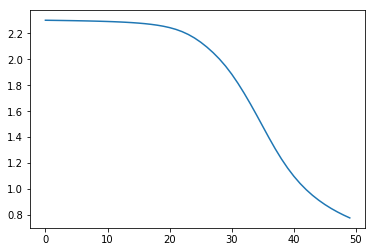

In [103]:
initialize_list = [XavierInitializer(), HeInitializer(), XavierInitializer()]
ac_list = [Tanh(), relu(), Softmax()]
nodes_num_list = [400, 200, 10]

SDNN6 = ScratchDeepNeuralNetrowkClassifier(nodes_num_list, ac_list, initialize_list, itr=50, b_size=20, lr=0.00001)
SDNN6.fit(Xt_train, yt_train)
plt.plot(SDNN6.L)


## 最適化手法(AdaGrad)

In [226]:
#平均値
class AdaGrad():
    def __init__(self, lr=0.01):
        self.lr = lr
        self.hw = 0
        self.hb = 0
        self.hw_mean=[]
        self.hb_mean=[]
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.hw += (np.mean(layer.LW, axis=0))**2 
        self.hb +=  (layer.LB)**2
        self.hw_mean.append(np.mean(self.hw))
        self.hb_mean.append(np.mean(self.hb))
        
        layer.W -= self.lr / np.sqrt(self.hw + 1e-7) * np.mean(layer.LW, axis=0)
        layer.B -= self.lr / np.sqrt(self.hb + 1e-7) * layer.LB

In [234]:
class AdaGrad2():
    def __init__(self, lr=0.01):
        self.lr = lr
        self.hw = 0
        self.hb = 0
        self.hw_mean=[]
        self.hb_mean=[]
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.hw += (layer.LW)**2 
        self.hb +=  (layer.LB)**2
        self.hw_mean.append(np.mean(self.hw))
        self.hb_mean.append(np.mean(self.hb))
        
        layer.W -= self.lr / np.sqrt(self.hw + 1e-7) * layer.LW
        layer.B -= self.lr / np.sqrt(self.hb + 1e-7) * layer.LB

### 動作テスト

In [1]:
initialize_list = [XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list = [AdaGrad(),AdaGrad(),AdaGrad()]
ac_list = [Tanh(), relu(), Softmax()]
nodes_num_list = [400, 200, 10]

SDNN7 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=4, b_size=1000, lr=0.00001)
SDNN7.fit(Xt_train, yt_train)
plt.plot(SDNN7.L)

#### Hの増加グラフ

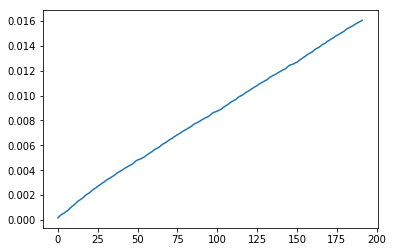

In [154]:
plt.plot(SDNN7.opt_list[0].h_mean)

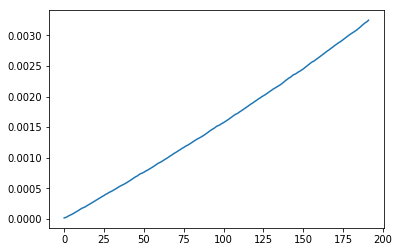

In [155]:
plt.plot(SDNN7.opt_list[1].h_mean)

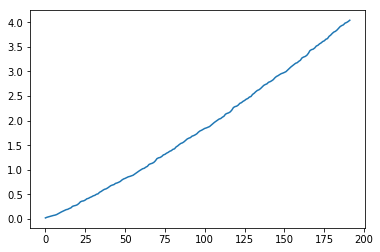

In [156]:
plt.plot(SDNN7.opt_list[2].h_mean)

### Hの効果を試してみる

0 >10 >20 >30 >40 >


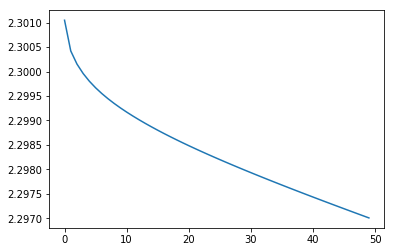

In [160]:
initialize_list = [XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list = [AdaGrad(),AdaGrad(),AdaGrad()]
ac_list = [Tanh(), relu(), Softmax()]
nodes_num_list = [400, 200, 10]

SDNN8 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=50, b_size=1000, lr=0.00001)
SDNN8.fit(Xt_train, yt_train)
plt.plot(SDNN8.L)

0 >10 >20 >30 >40 >


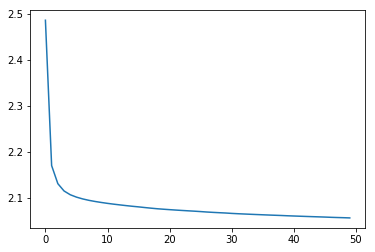

In [162]:
initialize_list = [XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list = [AdaGrad(),AdaGrad(),AdaGrad()]
ac_list = [Tanh(), relu(), Softmax()]
nodes_num_list = [400, 200, 10]

SDNN9 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=50, b_size=1000, lr=0.01)
SDNN9.fit(Xt_train, yt_train)
plt.plot(SDNN9.L)

AdaGradを採用すると、学習率を高くしても、収束してくれるようになる。

つまり、切れ込みが鋭くなり、エポックが少なくても収束してくれる。

0 >10 >20 >30 >40 >


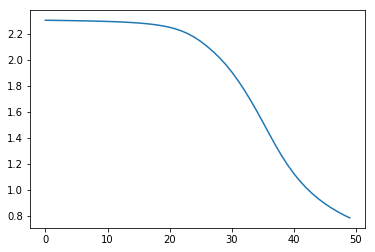

In [171]:
nodes_num_list = [400, 200, 10]
ac_list = [Tanh(), relu(), Softmax()]
initialize_list = [XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list = [SGD(),SGD(),SGD()]

SDNN10 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=50, b_size=100, lr=0.00001)
SDNN10.fit(Xt_train, yt_train)
plt.plot(SDNN10.L)

## 完成版クラス

In [175]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    多層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, nodes_num_list, ac_list, initialize_list, opt_list,
                 itr=1000, verbose=True, lr=0.00001, sigma=0.01, b_size=20):
        self.verbose = verbose
        self.itr = itr
        self.lr = lr                                     #学習率
        self.sigma = sigma                       #ガウス分布の標準偏差
        self.b_size = b_size
        self.L = []
        self.FC = {}                                  #各レイヤー格納辞書
        self.network = len(nodes_num_list)
        self.n_nodes = {i: nodes_num_list[i] for i in range(self.network)}
        self.activation = {i: ac_list[i] for i in range(self.network)}
        self.initialize_list = initialize_list
        for i in range(len(self.initialize_list)):
            self.initialize_list[i].sigma = self.sigma
        self.opt_list = opt_list
        for i in range(len(self.opt_list)):
            self.opt_list[i].lr = self.lr

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #各レイヤーインスタンス化 
        Z, LZ = [],[]
        for i in range(self.network):
            if i == 0:
                self.FC[i] = FC(X.shape[1], self.n_nodes[i], self.initialize_list[i], self.opt_list[i])
            else:
                self.FC[i] = FC(self.n_nodes[i-1], self.n_nodes[i], self.initialize_list[i], self.opt_list[i])
            Z.append(np.array([]))
            LZ.append(np.array([]))
        
        #エポック
        itr_count = 0
        for _ in range(self.itr):
            if itr_count%10 == 0:
                print(itr_count,">", end="")
            Lbatch = np.array([])
            
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.b_size)
            for mini_X_train, mini_y_train in get_mini_batch:
            
                """フォワード
                """
                for i in range(self.network):
                    if i == 0:
                        A = self.FC[i].forward(mini_X_train)
                        Z[i] = self.activation[i].forward(A)
                    else:
                        A = self.FC[i].forward(Z[i-1])
                        Z[i] = self.activation[i].forward(A)

                """バックプロパゲーション
                """
                for i in range(self.network)[::-1]:
                    if i == self.network-1:  #出力層
                        self.FC[i].LA = Z[i] - mini_y_train
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i-1], i)
                    elif i == 0:  #入力層
                        self.FC[i].LA = self.activation[i].backward(LZ[i+1], self.FC[i].A)
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, mini_X_train, i)
                    else:  #隠れ層
                        self.FC[i].LA = self.activation[i].backward(LZ[i+1], self.FC[i].A)
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i-1], i)

                """損失関数
                """
                Ltmp = 0
                for i in range(self.b_size):
                    Ltmp += np.sum(mini_y_train[i] * np.log(Z[-1][i]))
                Lbatch = np.append(Lbatch, (Ltmp/ self.b_size) * -1)
                
            self.L.append(Lbatch.mean())    
            itr_count += 1
            #print("---end of epoc---")

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass

    def predict(self, Xt):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pZ = []
        for i in range(self.network):
            pZ.append(np.array([]))        

        for i in range(self.network):
            if i == 0:
                A = self.FC[i].forward(Xt)
                pZ[i] = self.activation[i].forward(A)
            else:
                A = self.FC[i].forward(pZ[i-1])
                pZ[i] = self.activation[i].forward(A)
                    
        return pZ[-1]


## 推定

### パターンA

0 >10 >20 >30 >40 >


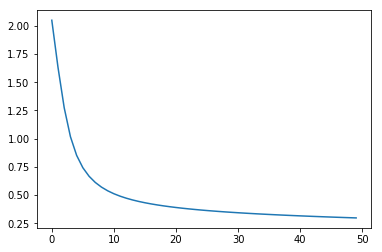

In [177]:
#イニシャライザーを機能させてみた
nodes_num_list = [400, 200, 10]
ac_list = [Tanh(), relu(), Softmax()]
initialize_list = [XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list = [SGD(),SGD(),SGD()]

SDNN10 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=50, b_size=100, lr=0.00001)
SDNN10.fit(Xt_train, yt_train)
plt.plot(SDNN10.L)

In [178]:
y_pred_raw = SDNN10.predict(Xt_val)
print(y_pred_raw.shape)

(12000, 10)


In [179]:
y_pred = np.array([])
for i in y_pred_raw:
    y_pred = np.append(y_pred, np.argmax(i))

print(y_pred.shape)
print(y_pred[0:5])

(12000,)
[4. 4. 7. 6. 6.]


In [180]:
yt_val_ = np.array([])
for i in yt_val:
    yt_val_ = np.append(yt_val_, np.argmax(i))
print(yt_val_.shape)
metrics.accuracy_score(yt_val_, y_pred)

(12000,)


0.9170833333333334

### パターンB

0 >10 >


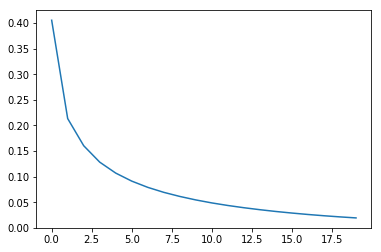

In [181]:
#学習率を上げて、エポックを短くしてみた
nodes_num_list = [400, 200, 10]
ac_list =               [Tanh(), relu(), Softmax()]
initialize_list =       [XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list =              [SGD(), SGD(), SGD()]

SDNN10 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=20, b_size=100, lr=0.001)
SDNN10.fit(Xt_train, yt_train)
plt.plot(SDNN10.L)

In [182]:
y_pred_raw = SDNN10.predict(Xt_val)
y_pred = np.array([])
for i in y_pred_raw:
    y_pred = np.append(y_pred, np.argmax(i))
metrics.accuracy_score(yt_val_, y_pred)

0.97625

### パターンC

0 >


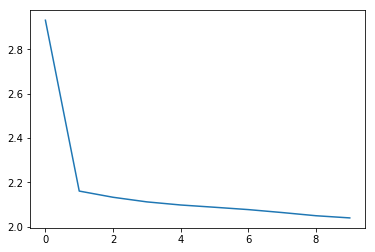

In [190]:
#最適化をAdaGradに変えて、さらに学習率を上げる
nodes_num_list = [400, 200, 10]
ac_list =               [Tanh(), relu(), Softmax()]
initialize_list =       [XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list =              [AdaGrad(), AdaGrad(), AdaGrad()]

SDNN11 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=10, b_size=50, lr=0.05)
SDNN11.fit(Xt_train, yt_train)
plt.plot(SDNN11.L)

### パターンD

0 >10 >20 >


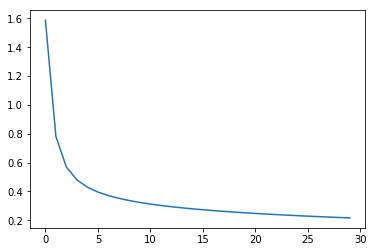

In [198]:
#隠れ層を３層にしてみる
nodes_num_list = [100, 400, 200, 10]
ac_list =               [relu(), Tanh(), relu(), Softmax()]
initialize_list =       [HeInitializer(), XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list =              [SGD(), SGD(), AdaGrad(), AdaGrad()]

SDNN12 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=30, b_size=1000, lr=0.0001)
SDNN12.fit(Xt_train, yt_train)
plt.plot(SDNN12.L)

In [201]:
#スコア
y_pred_raw = SDNN12.predict(Xt_val)
y_pred = np.array([])
for i in y_pred_raw:
    y_pred = np.append(y_pred, np.argmax(i))
metrics.accuracy_score(yt_val_, y_pred)

0.9388333333333333

### パターンE

0 >10 >20 >


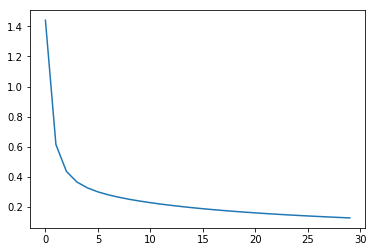

In [200]:
#隠れ層を４層にしてみる
nodes_num_list = [100, 400, 200, 100, 10]
ac_list =               [relu(), Tanh(), relu(), relu(), Softmax()]
initialize_list =       [HeInitializer(), XavierInitializer(), HeInitializer(), HeInitializer(), XavierInitializer()]
opt_list =              [SGD(), SGD(), AdaGrad(), SGD(), AdaGrad()]

SDNN13 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=30, b_size=1000, lr=0.0001)
SDNN13.fit(Xt_train, yt_train)
plt.plot(SDNN13.L)

In [202]:
#スコア
y_pred_raw = SDNN13.predict(Xt_val)
y_pred = np.array([])
for i in y_pred_raw:
    y_pred = np.append(y_pred, np.argmax(i))
metrics.accuracy_score(yt_val_, y_pred)

0.9601666666666666

### パターンF

0 >10 >20 >


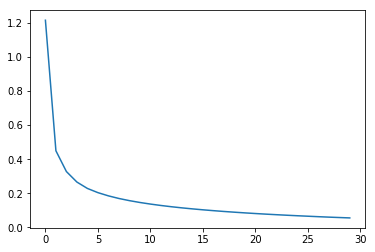

In [203]:
#隠れ層４層で全てLelu、SGDにしてみる
nodes_num_list = [100, 400, 200, 100, 10]
ac_list =               [relu(), relu(), relu(), relu(), Softmax()]
initialize_list =       [HeInitializer(), HeInitializer(), HeInitializer(), HeInitializer(), XavierInitializer()]
opt_list =              [SGD(), SGD(), SGD(), SGD(), SGD()]

SDNN13 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=30, b_size=1000, lr=0.0001)
SDNN13.fit(Xt_train, yt_train)
plt.plot(SDNN13.L)

In [204]:
#スコア
y_pred_raw = SDNN13.predict(Xt_val)
y_pred = np.array([])
for i in y_pred_raw:
    y_pred = np.append(y_pred, np.argmax(i))
metrics.accuracy_score(yt_val_, y_pred)

0.9719166666666667

### パターンG

0 >10 >


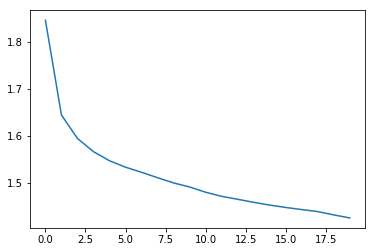

In [231]:
#隠れ層４層で全てLelu、AdaGradにしてみる
nodes_num_list = [100, 400, 200, 100, 10]
ac_list =               [relu(), relu(), relu(), relu(), Softmax()]
initialize_list =       [HeInitializer(), HeInitializer(), HeInitializer(),  HeInitializer(), XavierInitializer()]
opt_list =              [AdaGrad(), AdaGrad(), AdaGrad(), AdaGrad(), AdaGrad()]

SDNN14 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=20, b_size=100, lr=0.01)
SDNN14.fit(Xt_train, yt_train)
plt.plot(SDNN14.L)

0 >10 >


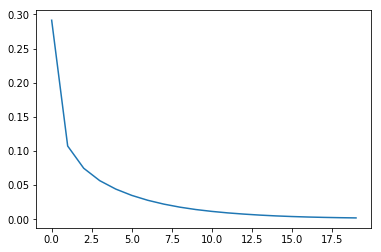

In [235]:
#AdaGradを平均取らないコードに変える
nodes_num_list = [100, 400, 200, 100, 10]
ac_list =               [relu(), relu(), relu(), relu(), Softmax()]
initialize_list =       [HeInitializer(), HeInitializer(), HeInitializer(),  HeInitializer(), XavierInitializer()]
opt_list =              [AdaGrad2(), AdaGrad2(), AdaGrad2(), AdaGrad2(), AdaGrad2()]

SDNN15 = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=20, b_size=100, lr=0.01)
SDNN15.fit(Xt_train, yt_train)
plt.plot(SDNN15.L)

In [236]:
#スコア
y_pred_raw = SDNN15.predict(Xt_val)
y_pred = np.array([])
for i in y_pred_raw:
    y_pred = np.append(y_pred, np.argmax(i))
metrics.accuracy_score(yt_val_, y_pred)

0.975